On effectue le pricing de plusieurs options dans le modèle de Jacobi.

In [1]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_hermitenorm, factorial
from scipy.stats import norm
from scipy.linalg import expm

On commence par pricer un call et une option digitale.

In [2]:
class JacobiPricing:
    def __init__(self, V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r):
        self.V0 = V0
        self.X0 = X0
        self.v_min = v_min
        self.v_max = v_max
        self.sigma = sigma
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.delta = delta
        self.mu_w = mu_w
        self.sigma_w = sigma_w
        self.r = r

    def Q(self, v):
        return (v-self.v_min) * (self.v_max-v) / (np.sqrt(self.v_max)-np.sqrt(self.v_min))**2
    
    def simulate_paths(self, V0, X0, n_T, T, n_paths):
        """Simulate n_paths trajectories of the process over [0, T] with n_T time steps"""
        dt = T / n_T
        sqrt_dt = np.sqrt(dt)

        # Initialize path array: shape (n_paths, n_T + 1, 2)
        paths = np.zeros((n_paths, n_T + 1, 2))
        paths[:, 0, 0] = V0  # Initial variance
        paths[:, 0, 1] = X0  # Initial log-price

        # Generate random normal variables: Z[:, :, 0] for dW1, Z[:, :, 1] for dW2
        Z = np.random.randn(n_paths, n_T, 2)

        for i in range(1, n_T + 1):
            V_prev = paths[:, i - 1, 0]
            X_prev = paths[:, i - 1, 1]
            Q_val = np.maximum(self.Q(V_prev), 0)
            sqrt_Q = np.sqrt(Q_val)

            # Variance process update
            dV = self.kappa * (self.theta - V_prev) * dt + self.sigma * sqrt_Q * sqrt_dt * Z[:, i - 1, 0]
            V_new = V_prev + dV

            # Log-price process update
            drift = (self.r - self.delta - V_prev / 2) * dt
            corr_term = self.rho * sqrt_Q * sqrt_dt * Z[:, i - 1, 0]
            uncorr_term = np.sqrt(np.maximum(0, V_prev - self.rho**2 * Q_val)) * sqrt_dt * Z[:, i - 1, 1]
            X_new = X_prev + drift + corr_term + uncorr_term

            # Store new values
            paths[:, i, 0] = V_new
            paths[:, i, 1] = X_new

        return paths
    
    def monte_carlo(self, V0, X0, paths, f):
        values = f(paths[:, -1, 1]) 
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        return mean, std


    def I_call(self, N, mu, nu):
        res = np.zeros(N+1)
        res[0] = np.exp(nu**2/2) * norm.cdf(nu-mu)
        for i in range(1, N+1):
            res[i] = eval_hermitenorm(i-1, mu) * np.exp(mu*nu) * norm.pdf(mu) + nu * res[i-1]
        return res

    def f_call(self, N, k, T):
        mu = (k-self.mu_w) / self.sigma_w
        nu = self.sigma_w
        I = self.I_call(N, mu, nu)
        f = np.zeros(N+1)
        f[0] = np.exp(-self.r*T+self.mu_w) * I[0] - np.exp(-self.r*T+k) * norm.cdf(-mu)
        for i in range(1, N+1):
            f[i] = np.exp(-self.r*T+self.mu_w) * (1/np.sqrt(factorial(i, exact=False))) * self.sigma_w * I[i-1]
        return f
    
    def f_digital(self, N, k, T):
        mu = (k-self.mu_w) / self.sigma_w
        f = np.zeros(N+1)
        f[0] = np.exp(-self.r * T) * norm.cdf(-mu)
        for i in range(1, N+1):
            f[i] = (np.exp(-self.r*T) / np.sqrt(factorial(i, exact=False))) * eval_hermitenorm(i-1, mu) * norm.pdf(mu)
        return f
    
    def f_call_bull_spread(self, N, k, T, eps):
        f = np.zeros(N+1)

        mu1 = (k-self.mu_w) / self.sigma_w
        nu1 = self.sigma_w
        I1 = self.I_call(N, mu1, nu1)
        f[0] = np.exp(-self.r*T+self.mu_w) * I1[0] - np.exp(-self.r*T+k) * norm.cdf(-mu1)
        for i in range(1, N+1):
            f[i] = np.exp(-self.r*T+self.mu_w) * (1/np.sqrt(factorial(i, exact=False))) * self.sigma_w * I1[i-1]

        mu2 = (k+eps-self.mu_w) / self.sigma_w
        nu2 = self.sigma_w
        I2 = self.I_call(N, mu2, nu2)
        f[0] = np.exp(-self.r*T+self.mu_w) * I2[0] - np.exp(-self.r*T+k+eps) * norm.cdf(-mu2)
        for i in range(1, N+1):
            f[i] = np.exp(-self.r*T+self.mu_w) * (1/np.sqrt(factorial(i, exact=False))) * self.sigma_w * I2[i-1]

        return f/eps

    
    def pi(self, N):
        p = 0
        h = {}
        h_inv = []
        for d in range(0, N+1):
            for i in range(0, d+1):
                h[(i, d-i)] = p
                h_inv.append((i, d-i))
                p += 1
        return h, np.array(h_inv)
    
    def H(self, m, n, v, x):
        return (v**m) * (1/np.sqrt(factorial(n, exact=False))) * eval_hermitenorm(n, (x-self.mu_w)/self.sigma_w)

    def l(self, N, T):
        M = (N+1) * (N+2) // 2
        h, h_inv = self.pi(N)
        l = np.zeros(N+1)

        H_lst = np.zeros(M)
        for i in range(M):
            (m, n) = h_inv[i]
            H_lst[i] = self.H(m, n, self.V0, self.X0)

        # Matrix G
        G = np.zeros((M, M))
        for d in range(0, N+1):
            for i in range(0, d+1):
                (m, n) = (i, d-i)
                if m >= 2:
                    G[h[(m-2,n)], h[(m,n)]] = -self.sigma**2 * m * (m-1) * self.v_max * self.v_min / (2 * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if m >=1 and n >= 1:
                    G[h[(m-1,n-1)], h[(m,n)]] = -self.sigma * self.rho * m * np.sqrt(n) * self.v_min * self.v_max / (self.sigma_w * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if m >= 1:
                    G[h[(m-1,n)], h[(m,n)]] = self.kappa * self.theta * m + (self.sigma**2 * m * (m-1) * (self.v_min + self.v_max)) / (2 * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if n >= 1:
                    G[h[(m,n-1)], h[(m,n)]] = (self.r-self.delta)*np.sqrt(n)/self.sigma_w + (self.sigma*self.rho*m*np.sqrt(n)*(self.v_min+self.v_max)) / (self.sigma_w*(np.sqrt(self.v_max)-np.sqrt(self.v_min))**2)
                if n >=2 and m <= N-1:
                    G[h[(m+1,n-2)], h[(m,n)]] = np.sqrt(n*(n-1)) / (2 * self.sigma_w**2)
                G[h[(m,n)], h[(m,n)]] = -self.kappa * m - (self.sigma**2 * m * (m-1)) / (2*(np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if n >=1 and m <= N-1:
                    G[h[(m+1,n-1)], h[(m,n)]] = - np.sqrt(n) / (2*self.sigma_w) - (self.sigma * self.rho * m * np.sqrt(n)) / (self.sigma_w*(np.sqrt(self.v_max)-np.sqrt(self.v_min))**2)

        E = np.zeros((M, N+1))
        for i in range(N+1):
            E[h[(0, i)], i] = 1
        G_exp = expm(T * G) 

        l = H_lst @ G_exp @ E

        return l
    
    def price_call(self, N, k, T):
        f = self.f_call(N, k, T)
        l = self.l(N, T)
        return np.dot(f, l)
    
    def price_digital(self, N, k, T):
        f = self.f_digital(N, k, T)
        l = self.l(N, T)
        return np.dot(f, l)
    
    def price_call_bull_spread(self, N, k, T, eps):
        f = self.f_call_bull_spread(N, k, T, eps)
        l = self.l(N, T)
        return np.dot(f, l)
    



Vérification polynômes de Hermite

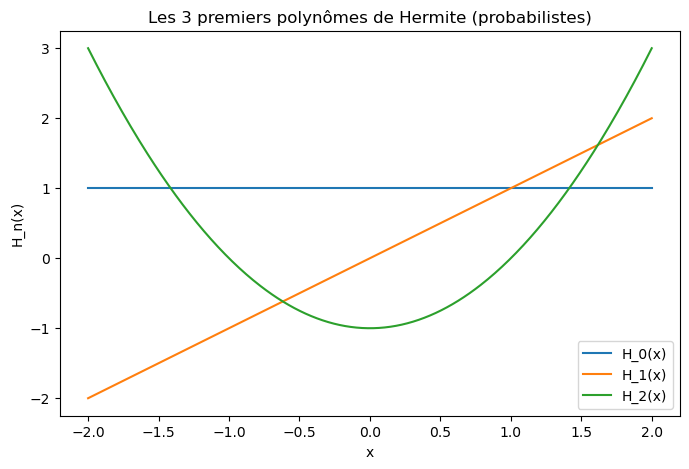

In [3]:
x = np.linspace(-2, 2, 400)

plt.figure(figsize=(8,5))
for n in range(3):
    Hn = eval_hermitenorm(n, x)
    plt.plot(x, Hn, label=f'H_{n}(x)')

plt.title('Les 3 premiers polynômes de Hermite (probabilistes)')
plt.xlabel('x')
plt.ylabel('H_n(x)')
plt.legend()
plt.show()

Le payoff du call est
$$f(x) = e^{-rT} \left( e^x - e^k \right)_+

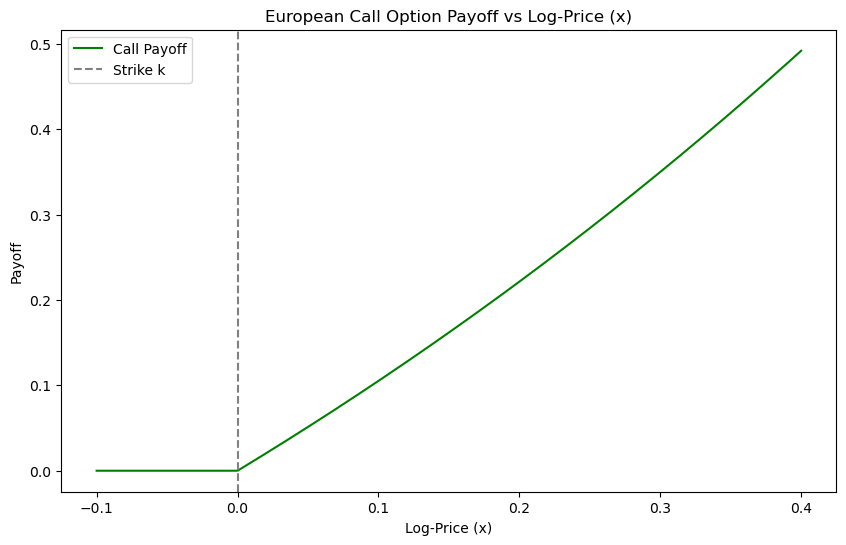

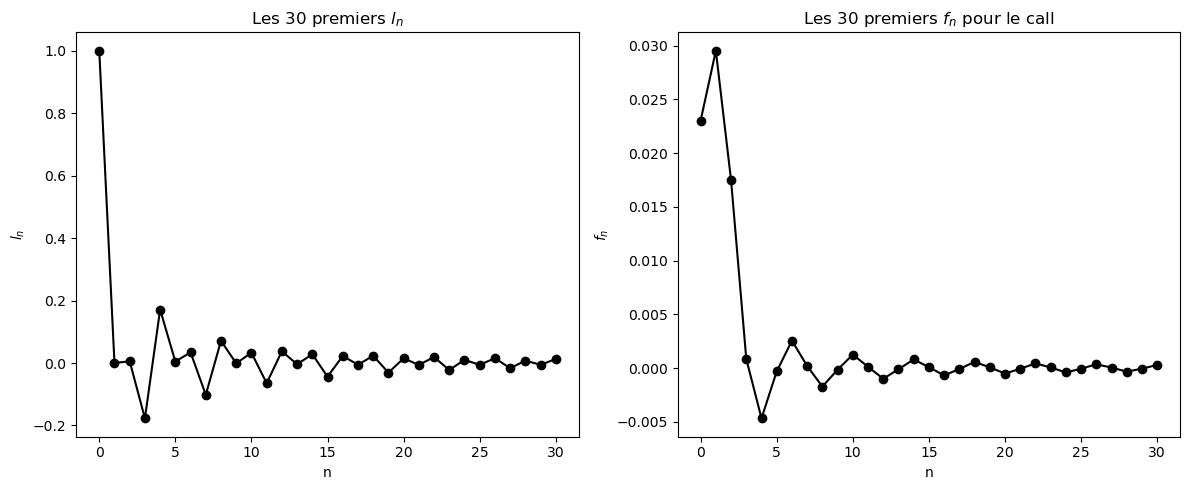

E(XT) par MC :  -0.001640353813519176
E(XT) par calcul : -0.0016666666666666666
V(XT) par MC 0.0033676715458871086
V(XT) par calcul 0.003333333333333333


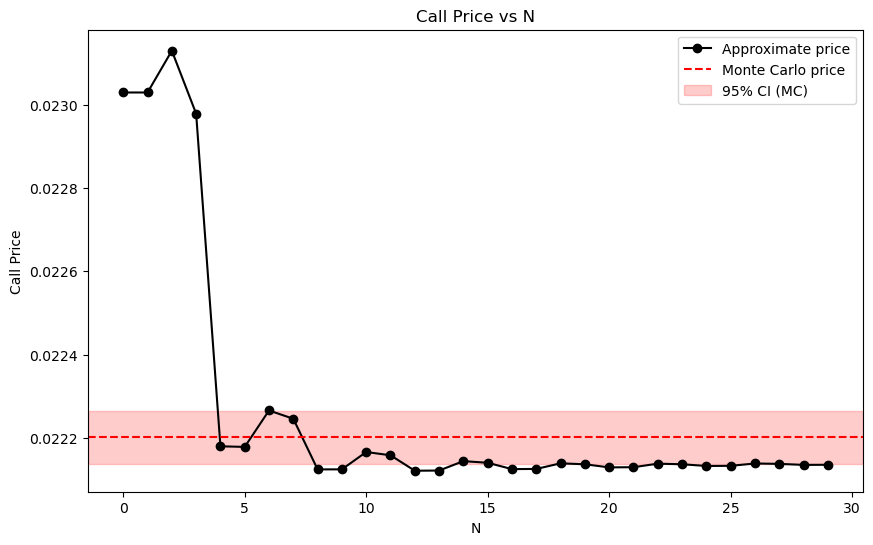

In [7]:
V0 = 0.04
X0 = 0.
v_min = 10**(-4)
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
k = 0.
T = 1/12
r = 0.
sigma_w = sigma
mu_w = 0.1

sigma_w = np.sqrt((V0-theta)*(1-np.exp(1-np.exp(-kappa*T)))/kappa + theta*T)
mu_w = X0 + (r-delta-theta/2)*T + (V0-theta)*(np.exp(-kappa*T)-1)/(2*kappa)

def payoff_call(x):
    return np.exp(-r*T) * np.maximum(np.exp(x) - np.exp(k), 0)

def m(x):
    return x

def sq(x):
    return x**2

# Grid of log-prices
x_vals = np.linspace(k - 0.1, k + 0.4, 500)
payoff_vals = payoff_call(x_vals)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, payoff_vals, label='Call Payoff', color='green')
plt.axvline(x=k, color='gray', linestyle='--', label='Strike k')
plt.title('European Call Option Payoff vs Log-Price (x)')
plt.xlabel('Log-Price (x)')
plt.ylabel('Payoff')
plt.legend()
plt.show()

model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

# Moments
N = 30
# Calcul des coefficients
l_n = model.l(N, T)
f_n = model.f_call(N, k, T)

# Tracé des graphes
plt.figure(figsize=(12, 5))

# Graphe de l_n
plt.subplot(1, 2, 1)
plt.plot(range(N + 1), l_n, marker='o', color='black', markersize=6)
plt.title("Les 30 premiers $l_n$")
plt.xlabel("n")
plt.ylabel("$l_n$")

# Graphe de f_n
plt.subplot(1, 2, 2)
plt.plot(range(N + 1), f_n, marker='o', color='black', markersize=6)
plt.title("Les 30 premiers $f_n$ pour le call")
plt.xlabel("n")
plt.ylabel("$f_n$")

plt.tight_layout()
plt.show()

# Pricing
n_paths=10**6
paths = model.simulate_paths(V0, X0, 50, T, n_paths)
call_price_mc = model.monte_carlo(V0, X0, paths, payoff_call)
m_mc, m_std_mc = model.monte_carlo(V0, X0, paths, m)
m2_mc, m2_std_mc = model.monte_carlo(V0, X0, paths, sq)
print("E(XT) par MC : ", m_mc)
print("E(XT) par calcul :", X0 + (r-delta-theta/2)*T + (V0-theta)*(np.exp(-kappa*T)-1)/(2*kappa))
print("V(XT) par MC", m2_mc-m_mc**2)
print("V(XT) par calcul", (V0-theta)*(1-np.exp(1-np.exp(-kappa*T)))/kappa + theta*T)

Ns = [i for i in range(30)]
call_prices = []

for N in Ns:
    prix_call = model.price_call(N, k, T)
    call_prices.append(prix_call)

# Tracé du graphe
plt.figure(figsize=(10, 6))
plt.plot(Ns, call_prices, marker='o', markersize=6, linestyle='-', color='black', label='Approximate price')

# Monte Carlo price and confidence interval
mean_mc, std_mc = call_price_mc
conf_int_low = mean_mc - 1.96 * std_mc / np.sqrt(n_paths)
conf_int_high = mean_mc + 1.96 * std_mc / np.sqrt(n_paths)

# Ligne horizontale pour le prix MC
plt.axhline(y=mean_mc, color='red', linestyle='--', label='Monte Carlo price')

# Bande d'intervalle de confiance 95%
plt.axhspan(conf_int_low, conf_int_high, xmin=0, xmax=1, color='red', alpha=0.2, label='95% CI (MC)')

plt.xlabel("N")
plt.ylabel("Call Price")
plt.title("Call Price vs N")
plt.legend()
plt.show()

In [8]:

print(call_prices)
print(call_price_mc)

[0.02302974467802421, 0.02302974467802421, 0.023130098081083204, 0.02297880503864347, 0.02217956141851561, 0.02217812422007145, 0.022265688741989587, 0.022245728243936454, 0.022124053179831966, 0.022124202700587087, 0.022165846599999272, 0.02215801164444345, 0.022120895648193625, 0.02212131980925648, 0.022143938852359615, 0.022139991638108848, 0.02212476137272245, 0.022125205644139445, 0.022138638326101655, 0.02213638691006403, 0.022128938661605816, 0.022129339278997923, 0.02213782332143908, 0.022136435914708714, 0.022132325281295512, 0.02213266938559436, 0.02213827514104672, 0.022137372489266036, 0.022134889429050352, 0.022135179435477256]
(0.022201225714499263, 0.03228124542282122)


Le payoff de l'option digitale est
$$f(x) = e^{-rT} \mathbb{1}_{[k, + \infty[} (x)$$

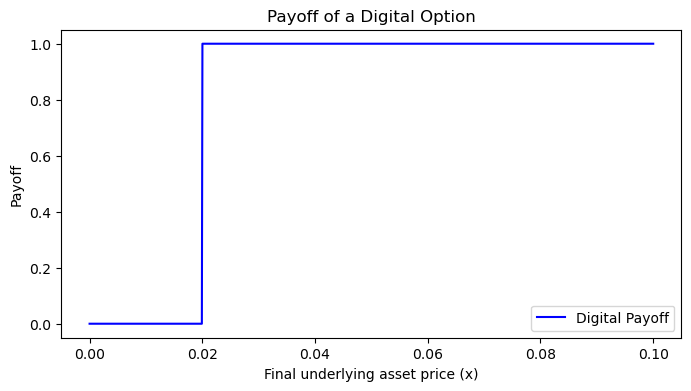

0.6881975578021556
0.7238823915176311
0.7265990065777672
0.726684679414029
0.7267228554932186
0.7262294514111018
0.7256508266574652
0.7251784046919666
0.7252273187995649
0.7251822957817893
0.7261181985002353


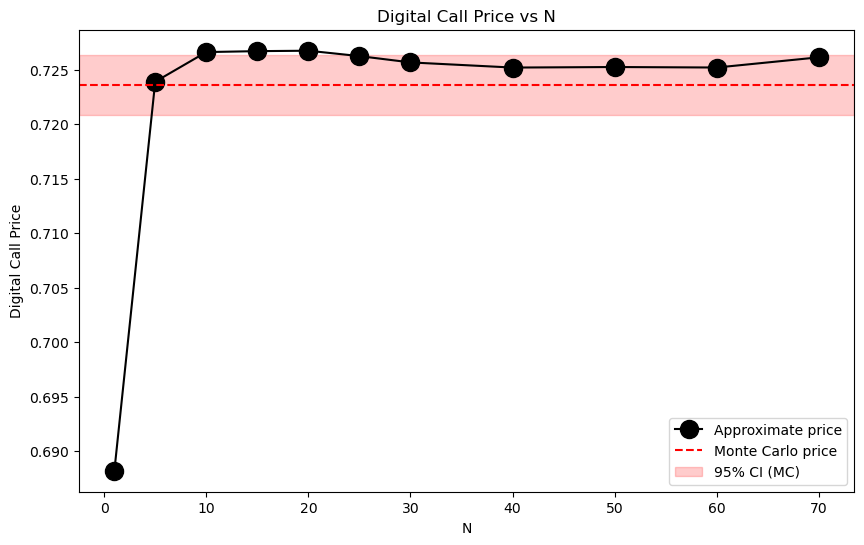

In [9]:
# Paramètres
V0 = 0.04
X0 = 0.05
v_min = 1e-4
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
k = 0.02
T = 1/12
r = 0.
sigma_w = sigma
mu_w = 0.1
sigma_w = np.sqrt((V0-theta)*(1-np.exp(1-np.exp(-kappa*T)))/kappa + theta*T)
mu_w = X0 + (r-delta-theta/2)*T + (V0-theta)*(np.exp(-kappa*T)-1)/(2*kappa)

def payoff_digital(x):
    return np.exp(-r*T) * np.where(x > k, 1.0, 0.0)

# X-axis: possible values of the underlying asset price at maturity
x_vals = np.linspace(0, 0.1, 1000)
y_vals = payoff_digital(x_vals)

# Plot the payoff graph
plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, label='Digital Payoff', color='blue')
plt.title('Payoff of a Digital Option')
plt.xlabel('Final underlying asset price (x)')
plt.ylabel('Payoff')
plt.legend()
plt.show()

# Model
model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

# Monte Carlo simulation
n_paths = 10**5
paths = model.simulate_paths(V0, X0, 10**2, T, n_paths)
digital_price_mc, digital_std_mc = model.monte_carlo(V0, X0, paths, payoff_digital)

# Confidence interval
std_error = digital_std_mc / np.sqrt(n_paths)
ci_low = digital_price_mc - 1.96 * std_error
ci_high = digital_price_mc + 1.96 * std_error

# Price approximation for various N
Ns = [1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70]
digital_prices = []
for N in Ns:
    price = model.price_digital(N, k, T)
    digital_prices.append(price)
    print(price)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Ns, digital_prices, marker='o', markersize=13, linestyle='-', color='black', label='Approximate price')

# Monte Carlo reference line and 95% confidence interval
plt.axhline(y=digital_price_mc, color='red', linestyle='--', label='Monte Carlo price')
plt.axhspan(ci_low, ci_high, xmin=0, xmax=1, color='red', alpha=0.2, label='95% CI (MC)')

plt.xlabel("N")
plt.ylabel("Digital Call Price")
plt.title("Digital Call Price vs N")
plt.legend()
plt.show()


$$f_{\varepsilon} (x) = \frac{e^{-rT-k}}{\varepsilon} \left( (e^x-e^k)_+ - (e^x-e^{k+\varepsilon})_+ \right)$$

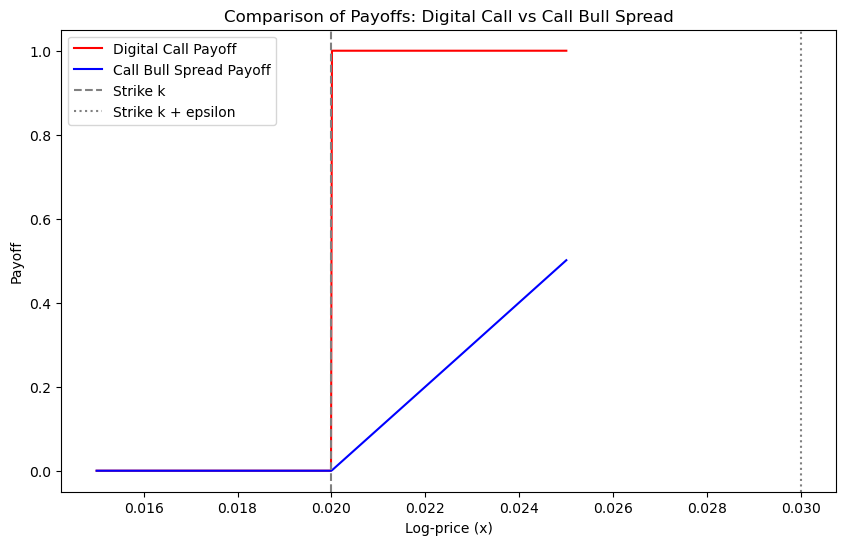

Prix Call bull spread 0.701921440626247
Prix Call digital 0.72578
N= 1 prix= 93.80881138187647
N= 5 prix= 18.69017003853856
N= 10 prix= 11.165539828383025
N= 15 prix= 9.828318510548389
N= 20 prix= 8.573507861836408
N= 25 prix= 7.9937798137108125
N= 30 prix= 7.365428413181311
N= 40 prix= 6.6405059098627515
N= 50 prix= 6.148296643675014
N= 60 prix= 5.7885825527968935
N= 70 prix= 5.512505896180868


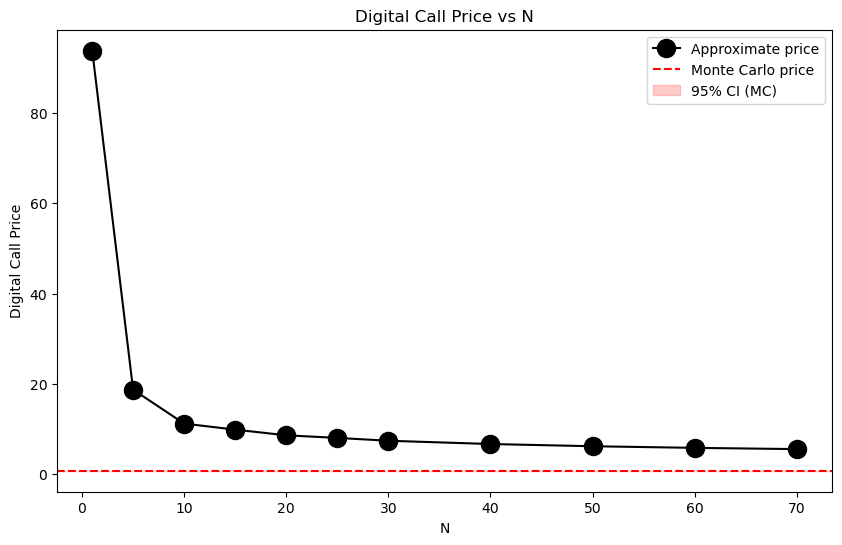

In [10]:
# Paramètres
V0 = 0.04
X0 = 0.05
v_min = 1e-4
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
k = 0.02
T = 1/12
r = 0.
eps = 10**(-2)
sigma_w = sigma
mu_w = 0.1

def payoff_digital(x):
    return np.exp(-r*T) * np.where(x > k, 1.0, 0.0)

def payoff_call_bull_spread(x):
    return np.exp(-r*T) * np.exp(-k) * (np.maximum(np.exp(x) - np.exp(k), 0) - np.maximum(np.exp(x) - np.exp(k+eps), 0)) / eps 

# Grid of log-prices
x_vals = np.linspace(k - 0.005, k + 0.005, 500)

# Evaluate the payoffs
payoff_dig = payoff_digital(x_vals)
payoff_bull = payoff_call_bull_spread(x_vals)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, payoff_dig, label='Digital Call Payoff', color='red')
plt.plot(x_vals, payoff_bull, label='Call Bull Spread Payoff', color='blue')
plt.axvline(x=k, color='gray', linestyle='--', label='Strike k')
plt.axvline(x=k+eps, color='gray', linestyle=':', label='Strike k + epsilon')

plt.title('Comparison of Payoffs: Digital Call vs Call Bull Spread')
plt.xlabel('Log-price (x)')
plt.ylabel('Payoff')
plt.legend()
plt.show()

# Model
model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

# Monte Carlo simulation
n_paths = 10**5
paths = model.simulate_paths(V0, X0, 10**2, T, n_paths)
digital_price_mc, digital_std_mc = model.monte_carlo(V0, X0, paths, payoff_digital)

# Monte Carlo pour le call bull spread
call_bull_spread_price_mc, call_bull_spread_std_mc = model.monte_carlo(V0, X0, paths, payoff_call_bull_spread)
print("Prix Call bull spread", call_bull_spread_price_mc)
print("Prix Call digital", digital_price_mc)

# Confidence interval
std_error = digital_std_mc / np.sqrt(n_paths)
ci_low = digital_price_mc - 1.96 * std_error
ci_high = digital_price_mc + 1.96 * std_error

# Price approximation for various N
Ns = [1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70]
digital_prices = []
for N in Ns:
    price = model.price_call_bull_spread(N, k, T, eps)
    digital_prices.append(price)
    print("N=", N, "prix=", price)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Ns, digital_prices, marker='o', markersize=13, linestyle='-', color='black', label='Approximate price')

# Monte Carlo reference line and 95% confidence interval
plt.axhline(y=digital_price_mc, color='red', linestyle='--', label='Monte Carlo price')
plt.axhspan(ci_low, ci_high, xmin=0, xmax=1, color='red', alpha=0.2, label='95% CI (MC)')

plt.xlabel("N")
plt.ylabel("Digital Call Price")
plt.title("Digital Call Price vs N")
plt.legend()
plt.show()


On simule des trajectoires.

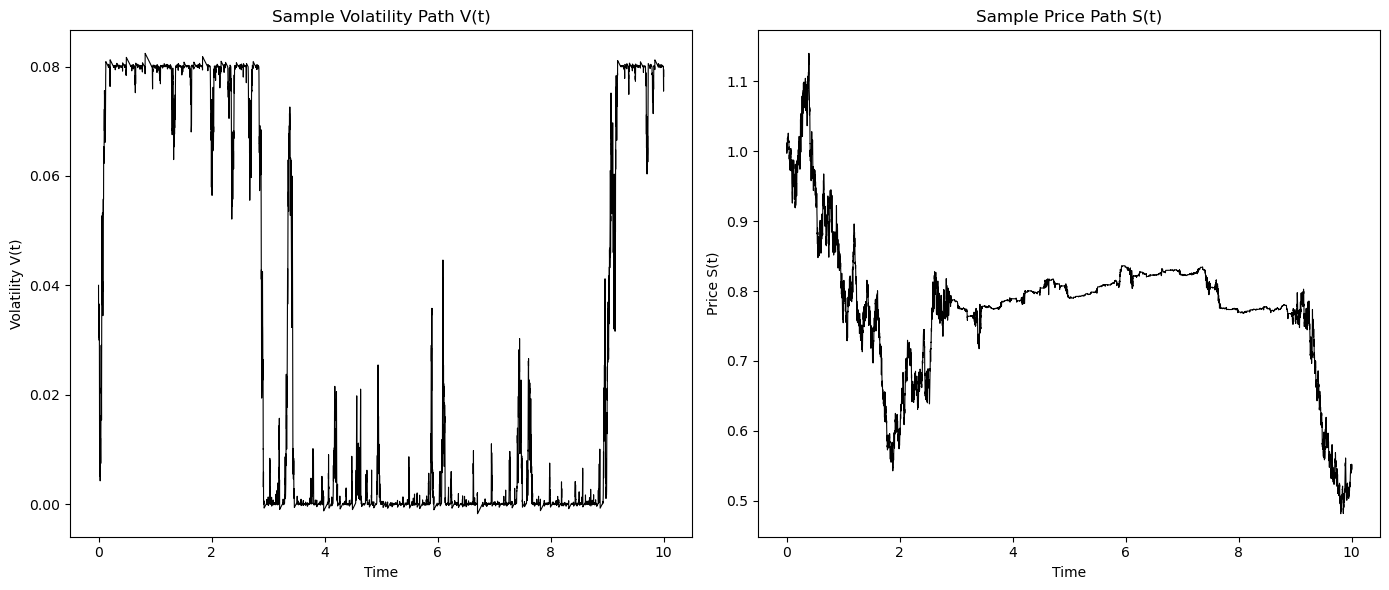

In [11]:
# Parameters
V0 = 0.04
X0 = 0.0
v_min = 1e-4
v_max = 0.08
sigma = 1.0
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.0
k = 0.0
T = 10            # total time horizon in years
n_T = 10000       # number of time steps
r = 0.0
sigma_w = sigma
mu_w = 0.005
n_paths = 1       # number of paths to simulate

# Model instantiation
model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

# Simulate multiple paths
paths = model.simulate_paths(V0, X0, n_T, T, n_paths)

# Extract time grid
t = np.linspace(0, T, n_T + 1)

# Plotting
plt.figure(figsize=(14, 6))

# Plot volatility paths in black
plt.subplot(1, 2, 1)
for i in range(n_paths):
    plt.plot(t, paths[i, :, 0], color='black', lw=0.8)
plt.xlabel('Time')
plt.ylabel('Volatility V(t)')
plt.title('Sample Volatility Path V(t)')

# Plot price paths in black
plt.subplot(1, 2, 2)
for i in range(n_paths):
    S = np.exp(paths[i, :, 1])  # Convert log-price to price
    plt.plot(t, S, color='black', lw=0.8)
plt.xlabel('Time')
plt.ylabel('Price S(t)')
plt.title('Sample Price Path S(t)')

plt.tight_layout()
plt.show()
